##### 1. 提取图像的SIFT特征点，构造全体特征点描述子的矩阵(695655, 128)

In [14]:
import matplotlib.pyplot as plt
from scipy.cluster.vq import vq
import scipy.cluster.vq as cluster
import numpy as np
import cv2

image_nums = 1000

def SIFT(img):
    I = cv2.imread(img)
    detector = cv2.xfeatures2d.SIFT_create()
    (_, features) = detector.detectAndCompute(I, None)  # 返回的第一个值是关键点信息，不需要
    return features

descriptors = SIFT('corel/0/0.jpg')
desc = []
desc.append(descriptors)
for i in range(10):
    for j in range(100):
        temp_des = SIFT('corel/'+str(i)+'/'+str(j+i*100)+'.jpg')                    # (1,128)向量
        desc.append(temp_des)                             # desc以数组形式保存所有描述子
        descriptors = np.vstack((descriptors, temp_des))  # 将所有的特征点描述子堆叠为矩阵(n,128)
descriptors = descriptors[1211:,:]
desc = desc[1:]
descriptors.shape

(695655, 128)

##### 3. 对所有关键点描述子进行k-means聚类

In [15]:
import random

# 计算新的聚类中心
def calcNewCentroids(cls_pos):
    Centroids_new = np.zeros((1, 128))
    for Centroid in cls_pos.keys():
        # 初始化新聚类中心坐标为128维0向量
        pos_new = np.zeros((1, 128))
        for pos in cls_pos[Centroid]:
            pos_new += pos    # 将该类中所有样本点坐标求和
        # 以各类中所有点的坐标的均值作为新的聚类中心点坐标
        pos_new /= len(cls_pos[Centroid])
        # 将新中心坐标添加到列表中
        Centroids_new = np.row_stack((Centroids_new, pos_new))
    return Centroids_new[1:,:]  # 不要第一行


def kmeans(X, k):
    n = X.shape[0]   # 数据点总数
    epoch = 0        # 迭代次数
    idxs = [random.randint(0,k) for _ in range(k)]
    Centroids = X[idxs] # 构造初始的中心点矩阵（1000x128）
    while(1):
        epoch += 1
        cls_pos = {}
        # 对于每个点，计算它到各中心的距离，得到它所属的类
        cls, _ = vq(X, Centroids)
        for i in range(n):
            cls_pos.setdefault(cls[i],[]).append(X[i])         # cls_pos：以类为key，其value为一个数组，保存属于该类的点坐标
        for j in range(k):
            if j not in cls_pos.keys():
                cls_pos.setdefault(j,[]).append(Centroids[j])  # 若某类没有点被分配进来，则该类只有类中心点一个点
        # 所有点均已分到相应的类中。下求新的聚类中心坐标
        Centroids_new = calcNewCentroids(cls_pos)
        # 当聚类中心不再变化时，停止迭代
        if (Centroids_new == Centroids).all():
            break
        # 更新聚类中心为新的聚类中心
        Centroids = Centroids_new
    # 返回聚类中心坐标及迭代次数
    return epoch, Centroids

In [16]:
# k为聚类数 调包计算时间：100/15.2s  500/26.2s  1000/32s  5000/43.5s  10000/1m5s  15000/1m36s
k = 1000
# words_num是视觉词汇数量（聚类中心数）
words_num = k
# 每隔10个descriptor采样一次
sampling_rate = 10
# voc是聚类中心数组，k行128列
# voc, _ = cluster.kmeans(descriptors[::sampling_rate,:],k,1)
epoch, voc = kmeans(descriptors[::sampling_rate,:], k)  # 1000 1min11s

##### 4. 遍历所有图像，求其对应的直方图向量

In [17]:
# 计算一幅图的直方图向量
def project(descriptors, words_num, voc): # 描述子向量，视觉词汇数，视觉词典
    imhist = np.zeros(words_num)   # 初始化直方图向量
    cls, _ = vq(descriptors, voc)  # 将该图的各个描述子分配到离它最近的聚类中心代表的类中
    for c in cls:
        imhist[c] += 1
    return imhist

In [26]:
imhists = np.zeros((image_nums, words_num))    # 100/1.3s  500/6.5s  1000/8.6s 2000/17.3s  5000/26.1s 10000/49s  15000/1m12s
for i in range(image_nums):
    imhists[i] = project(desc[i], words_num, voc)

In [29]:
# 这里是TF-IDF优化，后来发现效果不好就不用了
occurence_num = np.sum(imhists > 0, axis=0)       # 计算各视觉词汇在1000张图片中出现了几次，1x1000
IDF = np.log((image_nums) / (occurence_num + 1))  # 逆文档频率 = log(总图片数/(出现次数+1))，1x1000
for i in range(image_nums):
    imhists[i] = imhists[i] / np.sum(imhists[i]) * IDF  # imhists[i] / np.sum(imhists[i])是TF，即各视觉词汇在一幅图中出现的频率

##### 5. 给定一副输入图像，求该图像直方图向量与所有图像直方图向量之间的余弦相似度，然后降序排列，选择排在前10的图像作为检索输出

In [27]:
def cosin_dist(x, imhists):
    dists = []
    for i in range(image_nums):
        dists.append(np.dot(x, imhists[i]) / (np.linalg.norm(x, ord=2) * np.linalg.norm(imhists[i], ord=2)))
    return np.sort(dists)[::-1], np.argsort(dists)[::-1]

In [28]:
def euclid_dist(x, imhists):
    dists = []
    for i in range(image_nums):
        dists.append(np.sqrt(np.sum((x - imhists[i]) ** 2)))
    return np.sort(dists), np.argsort(dists)

输入图像如下：


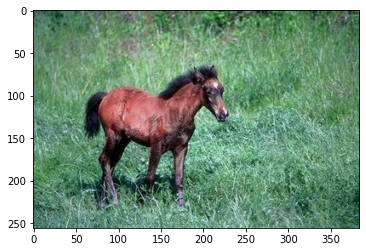

结果图像如下：


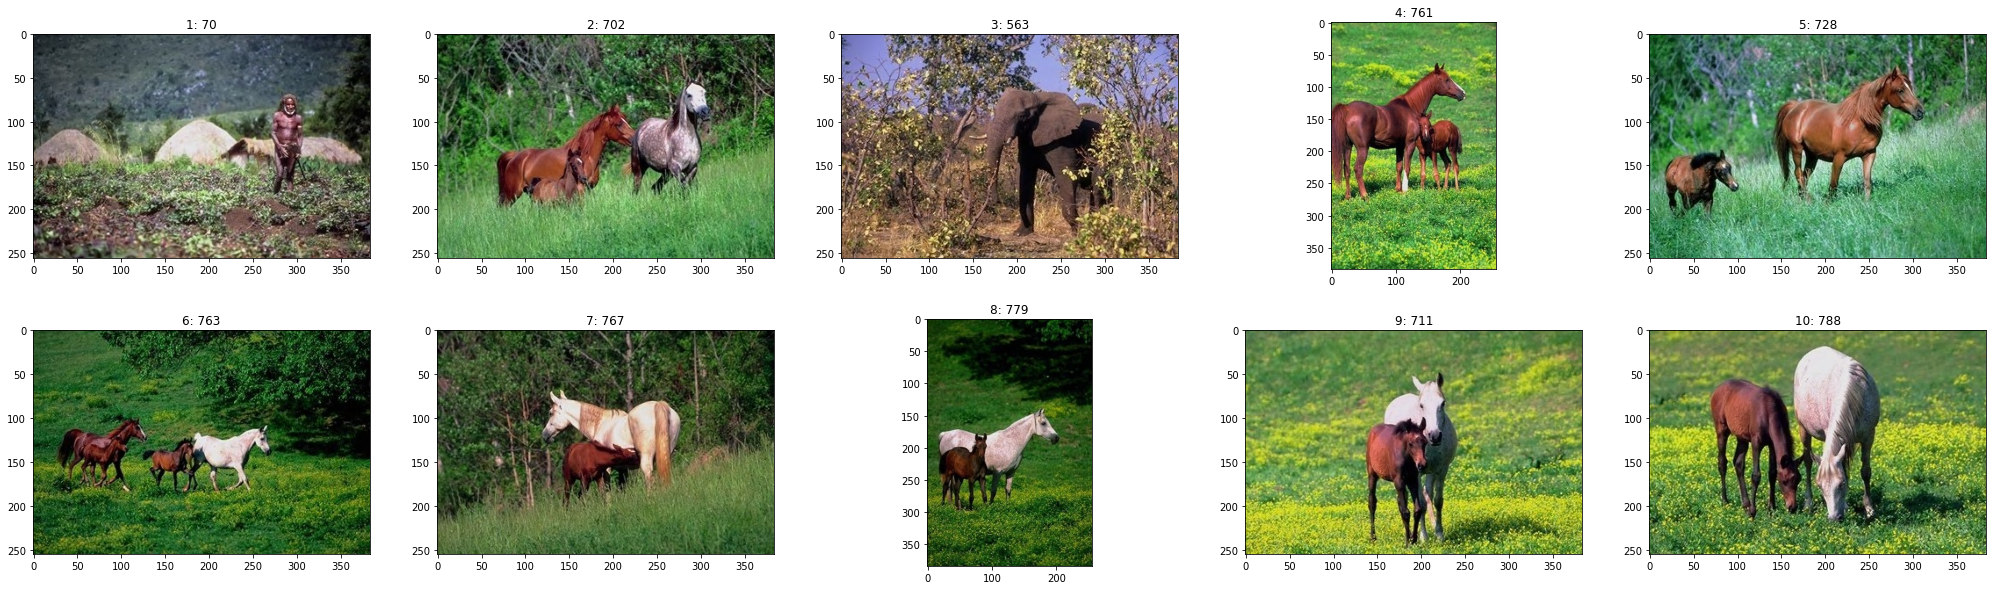

In [31]:
id = 720
input = imhists[id]
print('输入图像如下：')
img = plt.imread('corel/' + str(int(id/100)) + '/' + str(id) + '.jpg')
plt.imshow(img)
plt.show()

dists, idxs = cosin_dist(input, imhists)
print('结果图像如下：')
ids = idxs[1:11]
plt.subplots(2,5, figsize=(35,10))
for i, id in enumerate(ids):
    img = plt.imread('corel/' + str(int(id/100)) + '/' + str(id) + '.jpg')
    plt.subplot(2, 5, i+1)
    plt.title(str(i+1)+': '+str(id))
    plt.imshow(img)
    
plt.show()
# 0 2 3 4 5 7 准确率较高
# 1(海滩)图片容易和5(大象)/7(马)混淆
# 6(花)一旦背景有绿叶，容易和其他类别混
# 8(山峰/雪山)容易和其他类别混
# 9(食物)容易和1(非洲部落)/5(大象)/7(马)混

In [39]:
sum = 0
for id in range(0,1000):
    input = imhists[id]
    dists, idxs = cosin_dist(input, imhists)
    res_ids = idxs[1:11]
    for res_id in res_ids:
        l_bound = 100 * np.floor(id / 100)
        if(l_bound <= res_id <= l_bound + 99):
            sum +=1
print(sum / 10000)
# 有TF-IDF: 100+10sr 43.71%    500+10sr/46.43%    1000+10sr/47.23%    5000+10sr/48.00%    10000+10sr/48.38%    15000+10sr/48.08%
# 无TF-IDF: 100+10sr 48.30%    500+10sr/48.27%    1000+10sr/49.54%    5000+10sr/49.33%    10000+10sr/48.86%    15000+10sr/48.41%
# 各类别的检索准确率: 0/56.5%  1/8.6%  2/43.9%  3/76.5%  4/87.7%  5/55.5%  6/29.4%  7/65.9%  8/14.5%  9/20.9%

0.4852
